## Risk Matrix for Predictive Maintenance based on Central Limit Theorem

In [19]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load sensor means and stds
with open("sensor_stats.json", "r") as f:
    sensor_stats = json.load(f)

sensor_cols = list(sensor_stats.keys())

# Sensor name mapping dictionary (keep your original mapping)
sensor_name_map = {
    "sensor_0_avg": "Ambient temperature",
    "sensor_1_avg": "Wind absolute direction",
    "sensor_2_avg": "Wind relative direction",
    "wind_speed_3_avg": "Windspeed Average",
    "wind_speed_4_avg": "Estimated windspeed",
    "wind_speed_3_max": "Windspeed Maximum",
    "wind_speed_3_min": "Windspeed Minimum",
    "wind_speed_3_std": "Windspeed Standard Deviation",
    "sensor_5_avg": "Pitch angle Average",
    "sensor_5_max": "Pitch angle Maximum",
    "sensor_5_min": "Pitch angle Minimum",
    "sensor_5_std": "Pitch angle Standard Deviation",
    "sensor_6_avg": "Temperature in the hub controller",
    "sensor_7_avg": "Temperature in the top nacelle controller",
    "sensor_8_avg": "Temperature in the choke coils on the VCS-section",
    "sensor_9_avg": "Temperature on the VCP-board",
    "sensor_10_avg": "Temperature in the VCS cooling water",
    "sensor_11_avg": "Temperature in gearbox bearing on high speed shaft",
    "sensor_12_avg": "Temperature oil in gearbox",
    "sensor_13_avg": "Temperature in generator bearing 2 (Drive End)",
    "sensor_14_avg": "Temperature in generator bearing 1 (Non-Drive End)",
    "sensor_15_avg": "Temperature inside generator in stator windings phase 1",
    "sensor_16_avg": "Temperature inside generator in stator windings phase 2",
    "sensor_17_avg": "Temperature inside generator in stator windings phase 3",
    "sensor_18_avg": "Generator rpm in latest period Average",
    "sensor_18_max": "Generator rpm in latest period Maximum",
    "sensor_18_min": "Generator rpm in latest period Minimum",
    "sensor_18_std": "Generator rpm in latest period Standard Deviation",
    "sensor_19_avg": "Temperature in the split ring chamber",
    "sensor_20_avg": "Temperature in the busbar section",
    "sensor_21_avg": "Temperature measured by the IGBT-driver on the grid side inverter",
    "sensor_22_avg": "Actual phase displacement",
    "sensor_23_avg": "Averaged current in phase 1",
    "sensor_24_avg": "Averaged current in phase 2",
    "sensor_25_avg": "Averaged current in phase 3",
    "sensor_26_avg": "Grid frequency",
    "reactive_power_27_avg": "Possible grid capacitive reactive power Average",
    "reactive_power_27_max": "Possible grid capacitive reactive power Maximum",
    "reactive_power_27_min": "Possible grid capacitive reactive power Minimum",
    "reactive_power_27_std": "Possible grid capacitive reactive power Standard Deviation",
    "reactive_power_28_avg": "Possible grid inductive reactive power Average",
    "reactive_power_28_max": "Possible grid inductive reactive power Maximum",
    "reactive_power_28_min": "Possible grid inductive reactive power Minimum",
    "reactive_power_28_std": "Possible grid inductive reactive power Standard Deviation",
    "power_29_avg": "Possible grid active power Average",
    "power_29_max": "Possible grid active power Maximum",
    "power_29_min": "Possible grid active power Minimum",
    "power_29_std": "Possible grid active power Standard Deviation",
    "power_30_avg": "Grid power Average",
    "power_30_max": "Grid power Maximum",
    "power_30_min": "Grid power Minimum",
    "power_30_std": "Grid power Standard Deviation",
    "sensor_31_avg": "Grid reactive power Average",
    "sensor_31_max": "Grid reactive power Maximum",
    "sensor_31_min": "Grid reactive power Minimum",
    "sensor_31_std": "Grid reactive power Standard Deviation",
    "sensor_32_avg": "Averaged voltage in phase 1",
    "sensor_33_avg": "Averaged voltage in phase 2",
    "sensor_34_avg": "Averaged voltage in phase 3",
    "sensor_35_avg": "Temperature measured by the IGBT-driver on the rotor side inverter phase1",
    "sensor_36_avg": "Temperature measured by the IGBT-driver on the rotor side inverter phase2",
    "sensor_37_avg": "Temperature measured by the IGBT-driver on the rotor side inverter phase3",
    "sensor_38_avg": "Temperature in HV transformer phase L1",
    "sensor_39_avg": "Temperature in HV transformer phase L2",
    "sensor_40_avg": "Temperature in HV transformer phase L3",
    "sensor_41_avg": "Temperature oil in hydraulic group",
    "sensor_42_avg": "Nacelle direction",
    "sensor_43_avg": "Nacelle temperature",
    "sensor_44": "Active power - generator disconnected",
    "sensor_45": "Active power - generator connected in delta",
    "sensor_46": "Active power - generator connected in star",
    "sensor_47": "Reactive power - generator disconnected",
    "sensor_48": "Reactive power - generator connected in delta",
    "sensor_49": "Reactive power - generator connected in star",
    "sensor_50": "Total active power",
    "sensor_51": "Total reactive power",
    "sensor_52_avg": "Rotor rpm Average",
    "sensor_52_max": "Rotor rpm Maximum",
    "sensor_52_min": "Rotor rpm Minimum",
    "sensor_52_std": "Rotor rpm Standard Deviation",
    "sensor_53_avg": "Temperature in the nose cone",
}

# Severity function
def compute_severity(value, mean, std):
    diff = abs(value - mean)
    if diff <= 1 * std:
        return 0
    elif diff <= 2 * std:
        return 1
    elif diff <= 3 * std:
        return 2
    else:
        return 3
# Helper: Escalation logic
def evaluate_escalation(sensor, severity_series, id_series):
    escalation_events = []

    current_severity = None
    streak_ids = []

    for idx, (sev, cur_id) in enumerate(zip(severity_series, id_series)):
        if sev in [1, 2, 3]:
            if sev == current_severity and cur_id == streak_ids[-1] + 1:
                streak_ids.append(cur_id)
            else:
                # Check previous streak before resetting
                if current_severity:
                    escalation_events.extend(analyze_streak(sensor, current_severity, streak_ids))
                current_severity = sev
                streak_ids = [cur_id]
        else:
            # Non-risk or break
            if current_severity:
                escalation_events.extend(analyze_streak(sensor, current_severity, streak_ids))
            current_severity = None
            streak_ids = []

    # Final streak check
    if current_severity:
        escalation_events.extend(analyze_streak(sensor, current_severity, streak_ids))

    return escalation_events

# Helper: Interpret escalation level
def analyze_streak(sensor, severity, streak_ids):
    duration = len(streak_ids) * 10  # minutes
    if severity == 1:
        if duration >= 240:
            level = "Immediate Action"
        elif duration >= 180:
            level = "Precaution Needed"
        elif duration >= 120:
            level = "Observation Needed"
        else:
            return []
    elif severity == 2:
        if duration >= 180:
            level = "Immediate Action"
        elif duration >= 120:
            level = "Precaution Needed"
        elif duration >= 60:
            level = "Observation Needed"
        else:
            return []
    elif severity == 3:
        if duration >= 120:
            level = "Immediate Action"
        elif duration >= 60:
            level = "Precaution Needed"
        elif duration >= 30:
            level = "Observation Needed"
        else:
            return []
    else:
        return []

    return [{
        'sensor': sensor,
        'severity': severity,
        'duration_min': duration,
        'level': level,
        'start_id': streak_ids[0],
        'end_id': streak_ids[-1]
    }]

    


# Events to process
events = [
    {"dataset": 0, "start": 52436, "end": 54447},
    {"dataset": 10, "start": 52611, "end": 53591},
    {"dataset": 22, "start": 51888, "end": 52892},
    {"dataset": 26, "start": 52261, "end": 53269},
    {"dataset": 40, "start": 51363, "end": 55870},
    {"dataset": 42, "start": 52303, "end": 53309},
    {"dataset": 45, "start": 52731, "end": 53738},
    {"dataset": 68, "start": 52063, "end": 54076},
    {"dataset": 72, "start": 52497, "end": 53505},
    {"dataset": 73, "start": 52745, "end": 53753},
    {"dataset": 84, "start": 52623, "end": 53627},
]

def color_levels(val):
    color_map = {
        'Immediate Action': 'background-color: red; color: white;',
        'Precaution Needed': 'background-color: yellow; color: black;',
        'Observation Needed': 'background-color: green; color: white;'
    }
    return color_map.get(val, '')


for event in events:
    dataset_num = event["dataset"]
    start_id = event["start"]
    end_id = event["end"]

    # Load dataset
    file_path = fr"D:\Master Thesis New Data Set\CARE DATA SET\CARE_To_Compare\Wind Farm A\Wind Farm A\datasets\{dataset_num}.csv"
    df = pd.read_csv(file_path, delimiter=';')

    # Filter abnormal data within timestamp window
    df_abnormal = df[(df['train_test'] == 'prediction') & 
                     (df['status_type_id'] == 5) &
                     (df['id'] >= start_id) & (df['id'] <= end_id)].copy()

    # Apply severity scores
    for sensor in sensor_cols:
        mean = sensor_stats[sensor]['mean']
        std = sensor_stats[sensor]['std']
        df_abnormal[f"{sensor}_severity"] = df_abnormal[sensor].apply(lambda x: compute_severity(x, mean, std))

    # --- Escalation logic functions (already exist in your original code) ---
    all_alerts = []
    for sensor in sensor_cols:
        alerts = evaluate_escalation(
            sensor=sensor,
            severity_series=df_abnormal[f"{sensor}_severity"].values,
            id_series=df_abnormal["id"].values
        )
        all_alerts.extend(alerts)

    alert_df = pd.DataFrame(all_alerts)
    if not alert_df.empty:
        alert_df['sensor_name'] = alert_df['sensor'].map(sensor_name_map)
    else:
        # create empty dataframe with expected columns
        alert_df = pd.DataFrame(columns=['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id'])



    print(f"\n🚨 Escalation Events Detected for Dataset {dataset_num} (IDs {start_id}-{end_id}):\n")

    if not alert_df.empty:
        # Sort alerts to prioritize Immediate Action and longer durations
        alert_df_sorted = alert_df.sort_values(by=['severity', 'duration_min'], ascending=[False, False])
    
    # Pick one event per sensor - the highest severity & longest duration first
        alert_df_unique = alert_df_sorted.groupby('sensor').first().reset_index()
        alert_df_unique['sensor_name'] = alert_df_unique['sensor'].map(sensor_name_map)

        styled_table = alert_df_unique[['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id']]\
               .style.applymap(color_levels, subset=['level'])
        display(styled_table)


        fig, ax = plt.subplots(figsize=(12, len(alert_df_unique)*0.5))  # Adjust height based on rows
        ax.axis('off')  # Hide axes

    # Create a table from the DataFrame
        table = ax.table(cellText=alert_df_unique.values,
                 colLabels=alert_df_unique.columns,
                 cellLoc='center',
                 loc='center')

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(alert_df_unique.columns))))

        plt.tight_layout()
        plt.savefig("escalation_table.jpg", dpi=300)
        plt.close()


    else:
            print("No escalation events to display.")













🚨 Escalation Events Detected for Dataset 0 (IDs 52436-54447):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 10 (IDs 52611-53591):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 22 (IDs 51888-52892):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 26 (IDs 52261-53269):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 40 (IDs 51363-55870):



C:\Users\49157\AppData\Local\Temp\ipykernel_14264\1494997618.py:256: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = alert_df_unique[['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id']]\


,sensor_name,severity,duration_min,level,start_id,end_id
0,Temperature in the VCS cooling water,3,110,Precaution Needed,53540,53550
1,Temperature in gearbox bearing on high speed shaft,3,30,Observation Needed,52870,52872
2,Temperature oil in gearbox,3,450,Immediate Action,53292,53336
3,Temperature in generator bearing 2 (Drive End),1,1090,Immediate Action,53228,53336
4,Temperature in generator bearing 1 (Non-Drive End),1,1010,Immediate Action,53236,53336
5,Temperature inside generator in stator windings phase 1,1,1070,Immediate Action,53230,53336
6,Temperature inside generator in stator windings phase 2,1,1080,Immediate Action,53229,53336
7,Temperature inside generator in stator windings phase 3,1,1070,Immediate Action,53230,53336
8,Generator rpm in latest period Average,2,570,Immediate Action,53280,53336
9,Temperature in the split ring chamber,2,110,Observation Needed,53540,53550



🚨 Escalation Events Detected for Dataset 42 (IDs 52303-53309):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 45 (IDs 52731-53738):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 68 (IDs 52063-54076):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 72 (IDs 52497-53505):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 73 (IDs 52745-53753):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 84 (IDs 52623-53627):

No escalation events to display.


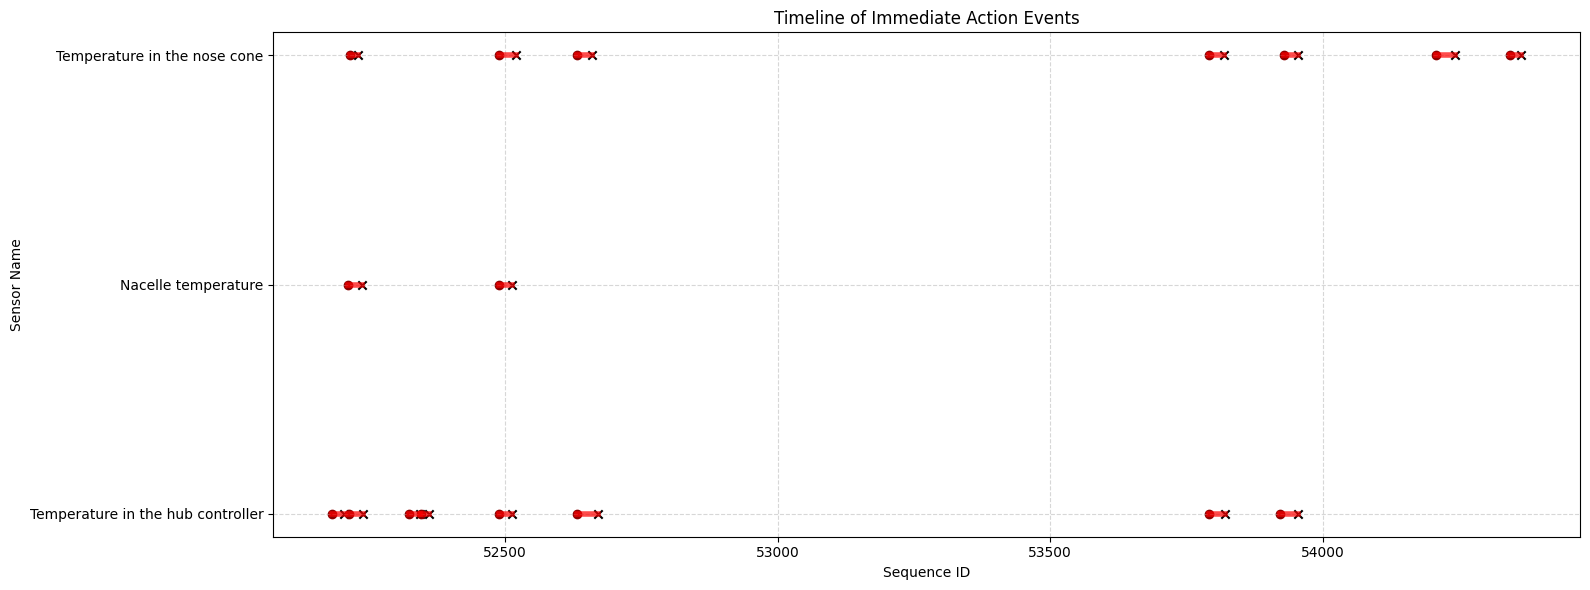

In [20]:
# Filter for Immediate Action level alerts only
immediate_action_df = alert_df[alert_df['level'] == 'Immediate Action'].copy()
if not immediate_action_df.empty:
    plt.figure(figsize=(16, 6))

    for idx, row in immediate_action_df.iterrows():
        plt.plot([row['start_id'], row['end_id']],
                 [row['sensor_name'], row['sensor_name']],
                 color='red', linewidth=4, alpha=0.7)
        plt.scatter(row['start_id'], row['sensor_name'], color='darkred', marker='o')
        plt.scatter(row['end_id'], row['sensor_name'], color='black', marker='x')

    plt.title('Timeline of Immediate Action Events')
    plt.xlabel('Sequence ID')
    plt.ylabel('Sensor Name')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No Immediate Action events detected.")


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load sensor means and stds
with open("sensor_stats.json", "r") as f:
    sensor_stats = json.load(f)

sensor_cols = list(sensor_stats.keys())

# Sensor name mapping dictionary
sensor_name_map = {
    "sensor_0_avg": "Ambient temperature",
    "sensor_1_avg": "Wind absolute direction",
    "sensor_2_avg": "Wind relative direction",
    "wind_speed_3_avg": "Windspeed Average",
    "wind_speed_4_avg": "Estimated windspeed",
    "wind_speed_3_max": "Windspeed Maximum",
    "wind_speed_3_min": "Windspeed Minimum",
    "wind_speed_3_std": "Windspeed Standard Deviation",
    "sensor_5_avg": "Pitch angle Average",
    "sensor_5_max": "Pitch angle Maximum",
    "sensor_5_min": "Pitch angle Minimum",
    "sensor_5_std": "Pitch angle Standard Deviation",
    "sensor_6_avg": "Temperature in the hub controller",
    "sensor_7_avg": "Temperature in the top nacelle controller",
    "sensor_8_avg": "Temperature in the choke coils on the VCS-section",
    "sensor_9_avg": "Temperature on the VCP-board",
    "sensor_10_avg": "Temperature in the VCS cooling water",
    "sensor_11_avg": "Temperature in gearbox bearing on high speed shaft",
    "sensor_12_avg": "Temperature oil in gearbox",
    "sensor_13_avg": "Temperature in generator bearing 2 (Drive End)",
    "sensor_14_avg": "Temperature in generator bearing 1 (Non-Drive End)",
    "sensor_15_avg": "Temperature inside generator in stator windings phase 1",
    "sensor_16_avg": "Temperature inside generator in stator windings phase 2",
    "sensor_17_avg": "Temperature inside generator in stator windings phase 3",
    "sensor_18_avg": "Generator rpm in latest period Average",
    "sensor_18_max": "Generator rpm in latest period Maximum",
    "sensor_18_min": "Generator rpm in latest period Minimum",
    "sensor_18_std": "Generator rpm in latest period Standard Deviation",
    "sensor_19_avg": "Temperature in the split ring chamber",
    "sensor_20_avg": "Temperature in the busbar section",
    "sensor_21_avg": "Temperature measured by the IGBT-driver on the grid side inverter",
    "sensor_22_avg": "Actual phase displacement",
    "sensor_23_avg": "Averaged current in phase 1",
    "sensor_24_avg": "Averaged current in phase 2",
    "sensor_25_avg": "Averaged current in phase 3",
    "sensor_26_avg": "Grid frequency",
    "reactive_power_27_avg": "Possible grid capacitive reactive power Average",
    "reactive_power_27_max": "Possible grid capacitive reactive power Maximum",
    "reactive_power_27_min": "Possible grid capacitive reactive power Minimum",
    "reactive_power_27_std": "Possible grid capacitive reactive power Standard Deviation",
    "reactive_power_28_avg": "Possible grid inductive reactive power Average",
    "reactive_power_28_max": "Possible grid inductive reactive power Maximum",
    "reactive_power_28_min": "Possible grid inductive reactive power Minimum",
    "reactive_power_28_std": "Possible grid inductive reactive power Standard Deviation",
    "power_29_avg": "Possible grid active power Average",
    "power_29_max": "Possible grid active power Maximum",
    "power_29_min": "Possible grid active power Minimum",
    "power_29_std": "Possible grid active power Standard Deviation",
    "power_30_avg": "Grid power Average",
    "power_30_max": "Grid power Maximum",
    "power_30_min": "Grid power Minimum",
    "power_30_std": "Grid power Standard Deviation",
    "sensor_31_avg": "Grid reactive power Average",
    "sensor_31_max": "Grid reactive power Maximum",
    "sensor_31_min": "Grid reactive power Minimum",
    "sensor_31_std": "Grid reactive power Standard Deviation",
    "sensor_32_avg": "Averaged voltage in phase 1",
    "sensor_33_avg": "Averaged voltage in phase 2",
    "sensor_34_avg": "Averaged voltage in phase 3",
    "sensor_35_avg": "Temperature measured by the IGBT-driver on the rotor side inverter phase1",
    "sensor_36_avg": "Temperature measured by the IGBT-driver on the rotor side inverter phase2",
    "sensor_37_avg": "Temperature measured by the IGBT-driver on the rotor side inverter phase3",
    "sensor_38_avg": "Temperature in HV transformer phase L1",
    "sensor_39_avg": "Temperature in HV transformer phase L2",
    "sensor_40_avg": "Temperature in HV transformer phase L3",
    "sensor_41_avg": "Temperature oil in hydraulic group",
    "sensor_42_avg": "Nacelle direction",
    "sensor_43_avg": "Nacelle temperature",
    "sensor_44": "Active power - generator disconnected",
    "sensor_45": "Active power - generator connected in delta",
    "sensor_46": "Active power - generator connected in star",
    "sensor_47": "Reactive power - generator disconnected",
    "sensor_48": "Reactive power - generator connected in delta",
    "sensor_49": "Reactive power - generator connected in star",
    "sensor_50": "Total active power",
    "sensor_51": "Total reactive power",
    "sensor_52_avg": "Rotor rpm Average",
    "sensor_52_max": "Rotor rpm Maximum",
    "sensor_52_min": "Rotor rpm Minimum",
    "sensor_52_std": "Rotor rpm Standard Deviation",
    "sensor_53_avg": "Temperature in the nose cone",
}

# Severity function
def compute_severity(value, mean, std):
    diff = abs(value - mean)
    if diff <= 1 * std:
        return 0
    elif diff <= 2 * std:
        return 1
    elif diff <= 3 * std:
        return 2
    else:
        return 3

# Helper: Escalation logic
def evaluate_escalation(sensor, severity_series, id_series):
    escalation_events = []

    current_severity = None
    streak_ids = []

    for idx, (sev, cur_id) in enumerate(zip(severity_series, id_series)):
        if sev in [1, 2, 3]:
            if sev == current_severity and cur_id == streak_ids[-1] + 1:
                streak_ids.append(cur_id)
            else:
                # Check previous streak before resetting
                if current_severity:
                    escalation_events.extend(analyze_streak(sensor, current_severity, streak_ids))
                current_severity = sev
                streak_ids = [cur_id]
        else:
            # Non-risk or break
            if current_severity:
                escalation_events.extend(analyze_streak(sensor, current_severity, streak_ids))
            current_severity = None
            streak_ids = []

    # Final streak check
    if current_severity:
        escalation_events.extend(analyze_streak(sensor, current_severity, streak_ids))

    return escalation_events

# Helper: Interpret escalation level
def analyze_streak(sensor, severity, streak_ids):
    duration = len(streak_ids) * 10  # minutes
    if severity == 1:
        if duration >= 240:
            level = "Immediate Action"
        elif duration >= 180:
            level = "Precaution Needed"
        elif duration >= 120:
            level = "Observation Needed"
        else:
            return []
    elif severity == 2:
        if duration >= 180:
            level = "Immediate Action"
        elif duration >= 120:
            level = "Precaution Needed"
        elif duration >= 60:
            level = "Observation Needed"
        else:
            return []
    elif severity == 3:
        if duration >= 120:
            level = "Immediate Action"
        elif duration >= 60:
            level = "Precaution Needed"
        elif duration >= 30:
            level = "Observation Needed"
        else:
            return []
    else:
        return []

    return [{
        'sensor': sensor,
        'severity': severity,
        'duration_min': duration,
        'level': level,
        'start_id': streak_ids[0],
        'end_id': streak_ids[-1]
    }]

# Events to process
events = [
    {"dataset": 0, "start": 52436, "end": 54447},
    {"dataset": 10, "start": 52611, "end": 53591},
    {"dataset": 22, "start": 51888, "end": 52892},
    {"dataset": 26, "start": 52261, "end": 53269},
    {"dataset": 40, "start": 51363, "end": 55870},
    {"dataset": 42, "start": 52303, "end": 53309},
    {"dataset": 45, "start": 52731, "end": 53738},
    {"dataset": 68, "start": 52063, "end": 54076},
    {"dataset": 72, "start": 52497, "end": 53505},
    {"dataset": 73, "start": 52745, "end": 53753},
    {"dataset": 84, "start": 52623, "end": 53627},
]

def color_levels(val):
    color_map = {
        'Immediate Action': 'background-color: red; color: white;',
        'Precaution Needed': 'background-color: yellow; color: black;',
        'Observation Needed': 'background-color: green; color: white;'
    }
    return color_map.get(val, '')

for event in events:
    dataset_num = event["dataset"]
    start_id = event["start"]
    end_id = event["end"]

    # Load dataset
    file_path = fr"D:\Master Thesis New Data Set\CARE DATA SET\CARE_To_Compare\Wind Farm A\Wind Farm A\datasets\{dataset_num}.csv"
    df = pd.read_csv(file_path, delimiter=';')

    # Filter abnormal data within timestamp window
    df_abnormal = df[(df['train_test'] == 'prediction') & 
                     (df['status_type_id'] == 5) &
                     (df['id'] >= start_id) & (df['id'] <= end_id)].copy()

    # Apply severity scores
    for sensor in sensor_cols:
        mean = sensor_stats[sensor]['mean']
        std = sensor_stats[sensor]['std']
        df_abnormal[f"{sensor}_severity"] = df_abnormal[sensor].apply(lambda x: compute_severity(x, mean, std))

    # --- Escalation logic functions (already exist in your original code) ---
    all_alerts = []
    for sensor in sensor_cols:
        alerts = evaluate_escalation(
            sensor=sensor,
            severity_series=df_abnormal[f"{sensor}_severity"].values,
            id_series=df_abnormal["id"].values
        )
        all_alerts.extend(alerts)

    alert_df = pd.DataFrame(all_alerts)
    if not alert_df.empty:
        alert_df['sensor_name'] = alert_df['sensor'].map(sensor_name_map)
    else:
        # create empty dataframe with expected columns
        alert_df = pd.DataFrame(columns=['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id'])

    print(f"\n🚨 Escalation Events Detected for Dataset {dataset_num} (IDs {start_id}-{end_id}):\n")

    if not alert_df.empty:
        # Sort alerts to prioritize Immediate Action and longer durations
        alert_df_sorted = alert_df.sort_values(by=['severity', 'duration_min'], ascending=[False, False])
    
        # Pick first 10 rows for display
        alert_df_unique = alert_df_sorted.head(10).reset_index(drop=True)
        alert_df_unique['sensor_name'] = alert_df_unique['sensor'].map(sensor_name_map)

        styled_table = alert_df_unique[['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id']]\
               .style.applymap(color_levels, subset=['level'])
        display(styled_table)

# Convert styled table to image with custom heading and font
        import dataframe_image as dfi

        # Ensure styled_table is defined with color coding
        styled_table = alert_df_unique[['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id']]\
                       .style.applymap(color_levels, subset=['level'])

        # Set custom caption as the table title
        styled_table.set_caption("Dataset 40 Predictive Maintenance Regime")

        # Export to high-quality PNG with increased font size
        dfi.export(styled_table, f"dataset_40_predictive_maintenance_table.png", dpi=600, table_conversion='matplotlib')

        # Optional: Adjust font size (requires additional styling)
        styled_table = styled_table.set_properties(**{'font-size': '14pt'})
        dfi.export(styled_table, f"dataset_40_predictive_maintenance_table.png", dpi=600, table_conversion='matplotlib')
    else:
        print("No escalation events to display.")


🚨 Escalation Events Detected for Dataset 0 (IDs 52436-54447):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 10 (IDs 52611-53591):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 22 (IDs 51888-52892):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 26 (IDs 52261-53269):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 40 (IDs 51363-55870):



C:\Users\49157\AppData\Local\Temp\ipykernel_9372\910168493.py:251: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = alert_df_unique[['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id']]\


,sensor_name,severity,duration_min,level,start_id,end_id
0,Temperature in the hub controller,2,580,Immediate Action,53234,53291
1,Temperature in the hub controller,2,190,Immediate Action,53540,53558
2,Temperature in the hub controller,2,160,Precaution Needed,53568,53583
3,Temperature in the hub controller,2,60,Observation Needed,53560,53565
4,Temperature in the hub controller,1,440,Immediate Action,52930,52973
5,Temperature in the hub controller,1,190,Precaution Needed,53793,53811
6,Temperature in the hub controller,1,150,Observation Needed,53074,53088
7,Temperature in the hub controller,1,150,Observation Needed,53843,53857
8,Temperature in the hub controller,1,140,Observation Needed,52987,53000
9,Temperature in the hub controller,1,120,Observation Needed,53222,53233


C:\Users\49157\AppData\Local\Temp\ipykernel_9372\910168493.py:259: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = alert_df_unique[['sensor_name', 'severity', 'duration_min', 'level', 'start_id', 'end_id']]\



🚨 Escalation Events Detected for Dataset 42 (IDs 52303-53309):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 45 (IDs 52731-53738):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 68 (IDs 52063-54076):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 72 (IDs 52497-53505):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 73 (IDs 52745-53753):

No escalation events to display.

🚨 Escalation Events Detected for Dataset 84 (IDs 52623-53627):

No escalation events to display.
